# Annotation

In this notebook, we'll explore how to annotate various data sets. Annotation broadly refers to a range of techniques spanning from anomaly/change point detection to segmentation. Such techniques are used in a diverse range of applications, for instance, the identification of extreme weather events, stock market crashes and fraudulent transactions. 

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from sktime.annotation.datagen import piecewise_normal_multivariate

np.random.seed(123)

%matplotlib widget

## 1. Data Generation

First, we'll generate some multivariate data that exhibits mean shifts (with constant covariance)

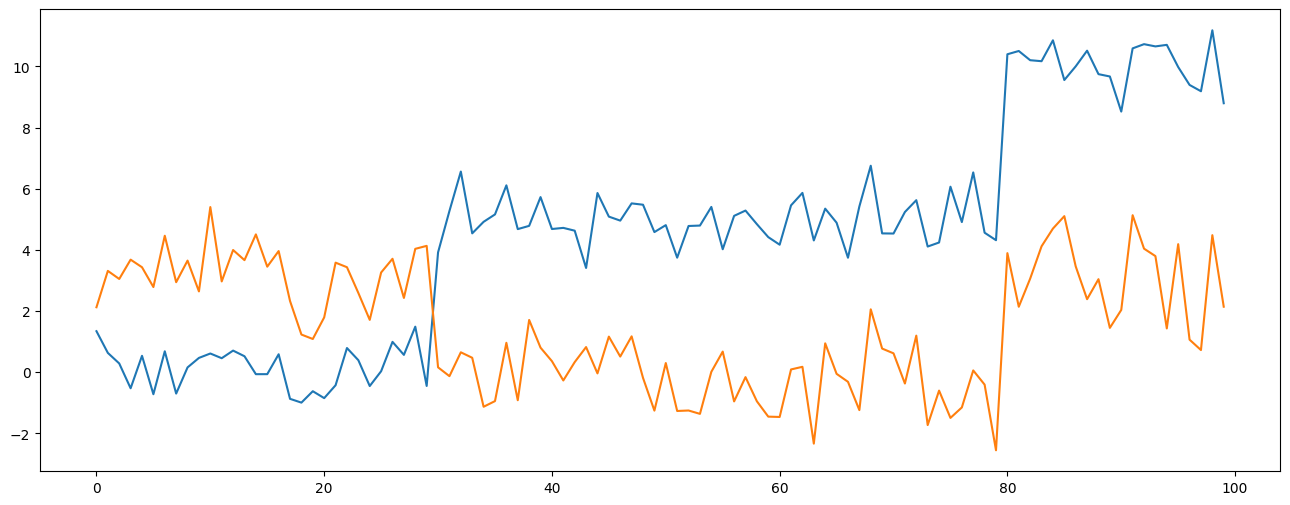

In [6]:
mv_mean = piecewise_normal_multivariate(
    means=[[0, 3], [5, 0], [10, 3]],
    lengths=[30, 50, 20],
    covariances=[
        [[0.5, 0.3], [0.3, 1.0]],
        [[0.5, 0.3], [0.3, 1.0]],
        [[0.5, 0.3], [0.3, 1.0]],
    ],
    random_state=279,
)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(mv_mean);

In the data space, this can be represented as such

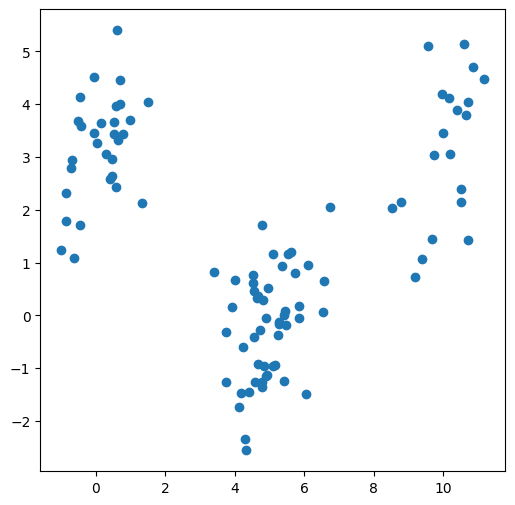

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(mv_mean[:, 0], mv_mean[:, 1], "o");

Secondly, we generate a multivariate timeseires by changing the covariance structure (from independent random variables, to highly negatively correlated, to highly correlated). This can be seen in the covariances matrices input below.

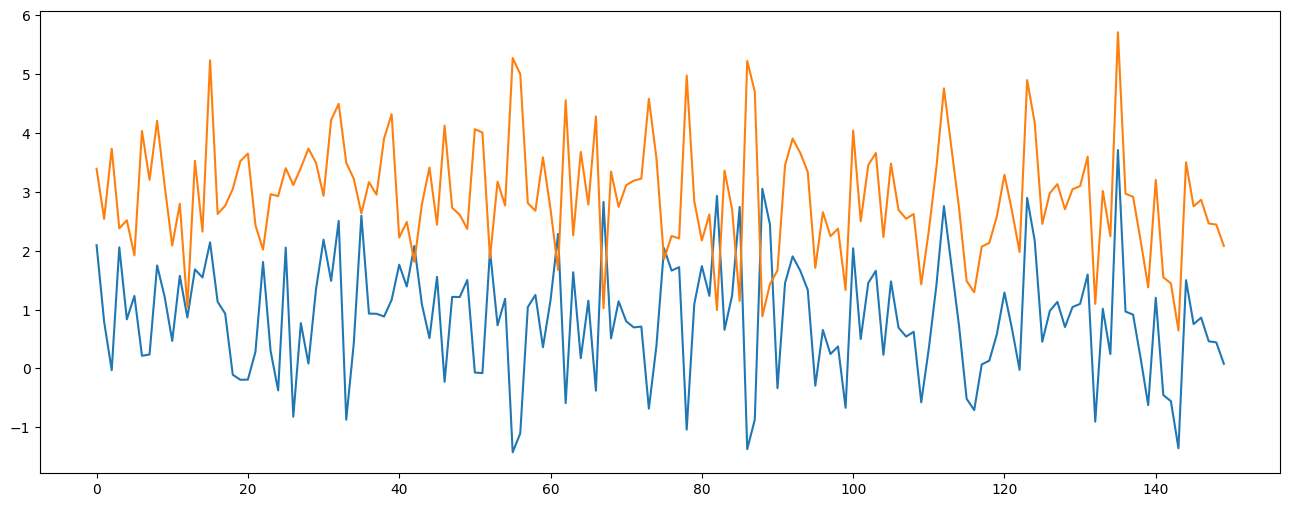

In [8]:
mv_cov = piecewise_normal_multivariate(
    means=[[1.1, 3], [1, 2.9], [1, 3]],
    lengths=[40, 50, 60],
    covariances=[
        [[1.0, 0.003], [0.003, 1.0]],
        [[1.0, -0.999], [-0.999, 1.0]],
        [[1.0, 1.0], [1.0, 1.0]],
    ],
    random_state=2354,
)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(mv_cov);

Representing this timeseries with changing covariace in the data space allows us to uncover interesting characteristics; the 45 degree angle line comes about from the phase of high correlation and the 135 degree line comes about from the phase of negative correlation.

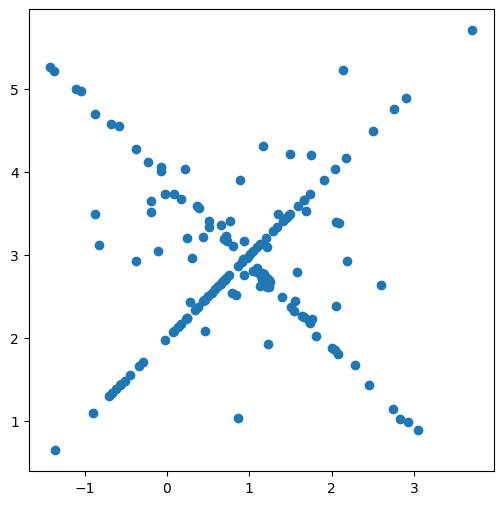

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(mv_cov[:, 0], mv_cov[:, 1], "o");

Note the different definitions of "dimension": we use a 2-dimensional array to represent tabular data, but also describe the dimensionality of data (in the data space above, which is the number of columns). Intrinsic dimensionality is something else entirely...

## 2. Data Analysis

Suppose that we want to understand phases and/or changing complex system regimes (with potentially hidden states). We will now explore different techniques to segment the data.

### HMM: Hidden Markov Model

A hidden Markov model (HMM) allows us to account for both observed events and hidden events that we think of as causal factors in our probabilistic model. This is done by fitting a sequence of hidden states to a sequence of observations, by finding the most likely path given the emission probabilities - (i.e. the probability that a particular observation
would be generated by a given hidden state), the transition probability (i.e. the probability of transitioning from one state to another or staying in the same state) and the initial probabilities - i.e. the belief of the probability distribution of hidden states at the
start of the observation sequence).

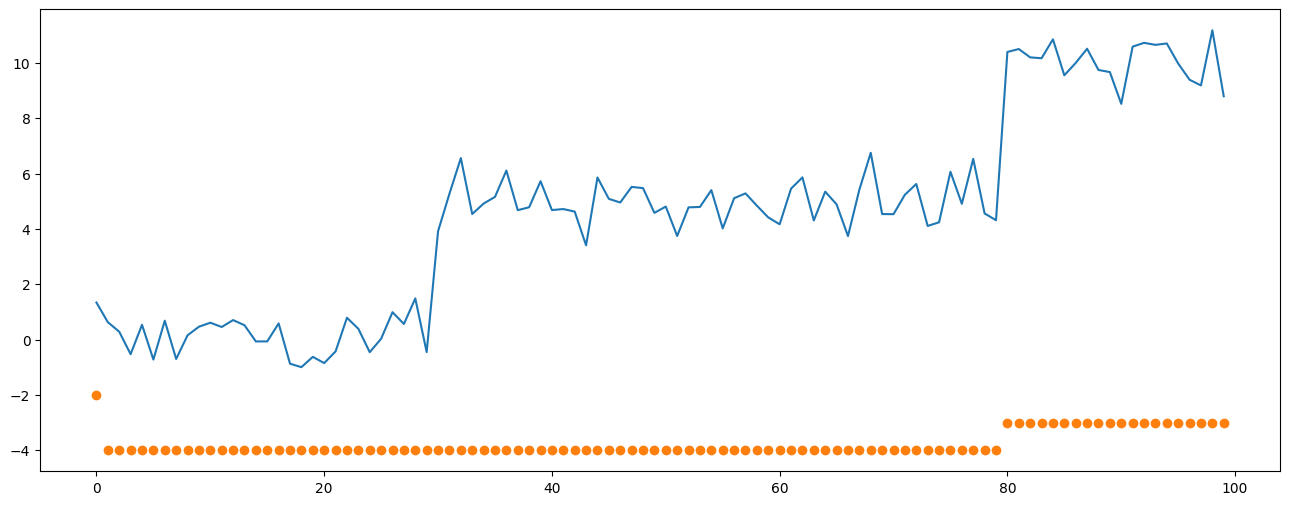

In [95]:
from sktime.annotation.hmm_learn import GMMHMM

X = mv_mean[:, 0]
model = GMMHMM(n_components=3, random_state=123)
model = model.fit(X)
labels = model.predict(X)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(X)
ax.plot(labels - 4, "o");

#### HIDALGO: Heterogeneous Intrinsic Dimensionality ALGOrithm

A fundamental paradigm in machine learning is that a small number of variables is often sufficient to describe high-dimensional data, where Intrinsic dimensionality (ID) is the minimum number of variables required. In most approaches for dimensionality reduction and manifold learning, the ID is assumed to be constant in the dataset. However, this assumption is often violated in the case of real-world data. Heterogeneous ID allows for data to be represented by a mixture model on the support on the union of K manifolds with varying dimensions. Points are then assigned to manifold k with corresponding dimensionality. Hidalgo extends this concept to a Bayesian framework which allows the identification (by Gibbs sampling) of regions in the data landscape where the ID can be considered constant. As such, Hidalgo offers robust method for unsupervised segmentation of high-dimensional data.

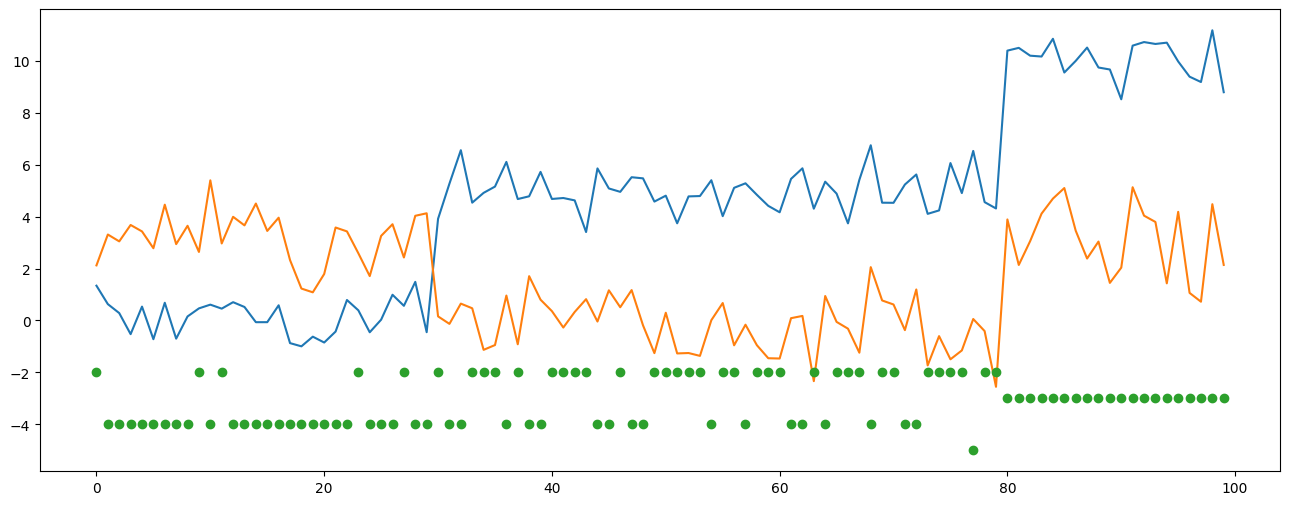

In [11]:
from sktime.transformations.series.hidalgo import Hidalgo

model = Hidalgo(K=3, burn_in=0.8, n_iter=100, seed=10)
fitted_model = model.fit(mv_mean)
z_mv_mean = fitted_model.transform(mv_mean)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(mv_mean)
ax.plot(z_mv_mean - 4, "o");

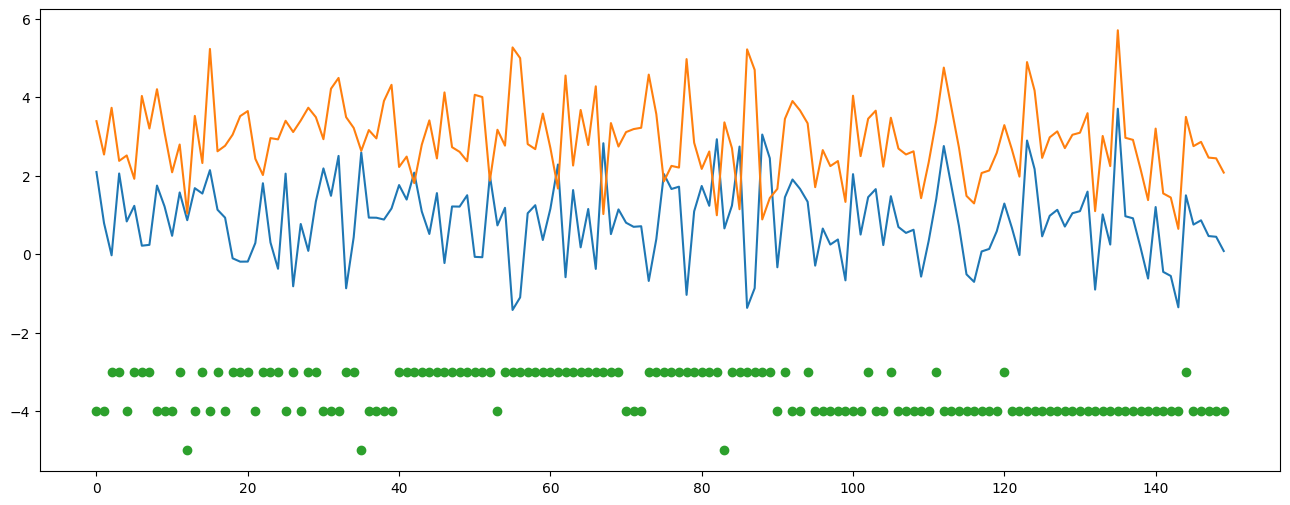

In [12]:
model = Hidalgo(K=2, burn_in=0.8, n_iter=1000, seed=148)
fitted_model = model.fit(mv_cov)
z_mv_cov = fitted_model.transform(mv_cov)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(mv_cov)
ax.plot(z_mv_cov - 4, "o");

#### STRAY: Search TRace AnomalY outlier estimator

STRAY is an extension of HDoutliers, a powerful algorithm for the detection of anomalous observations in a dataset which has (among other advantages) the ability to detect clusters of outliers in multi-dimensional data without requiring a model of the typical behavior of the system. However, it suffers from some limitations that affect its accuracy. STRAY is an extension of HDoutliers that uses extreme value theory for the anomalous threshold calculation, to deal with data streams that exhibit non-stationary behavior.

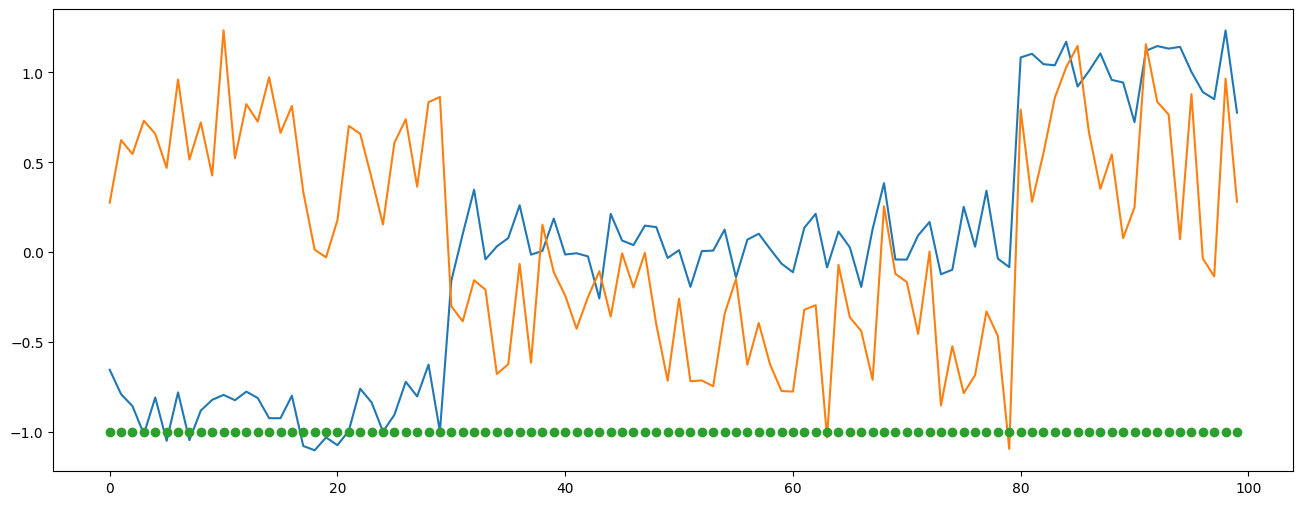

In [84]:
from sklearn.preprocessing import RobustScaler

from sktime.annotation.stray import STRAY

scaler = RobustScaler()
X = scaler.fit_transform(mv_mean)
model = STRAY(alpha=0.1)
y_actual = model.fit_transform(X)
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(X)
ax.plot(y_actual - 1, "o");

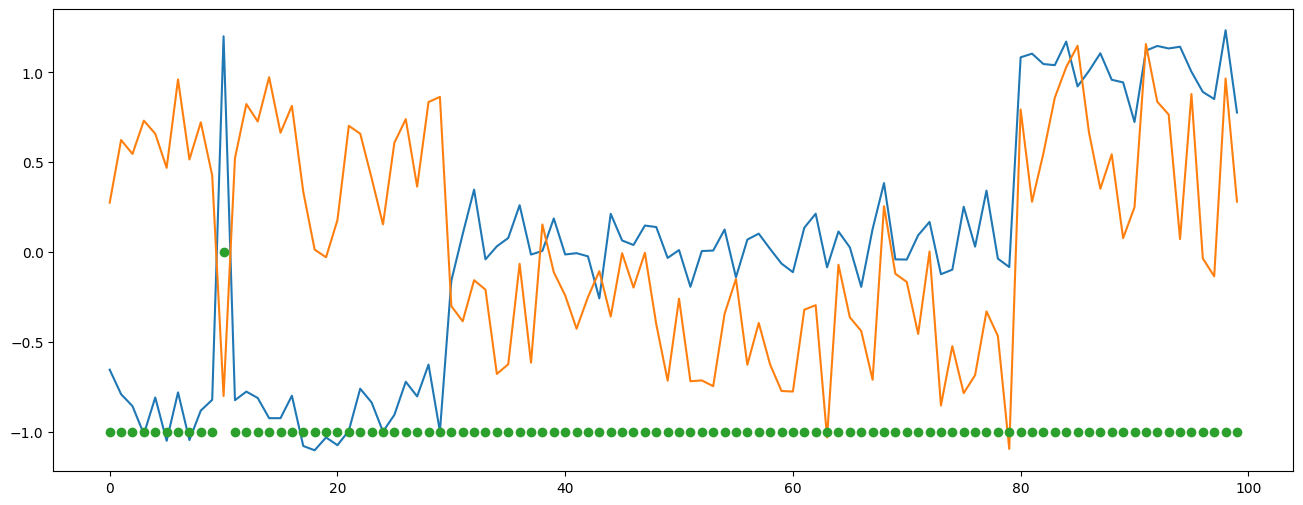

In [83]:
scaler = RobustScaler()
X = scaler.fit_transform(mv_mean)
X[10][0] = 1.2
X[10][1] = -0.8

model = STRAY(alpha=0.1)
y_actual = model.fit_transform(X)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(X)
ax.plot(y_actual - 1, "o");

## 3. Building Pipelines

sktime has a range of pre-processing transformations available for use, to build analysis pipelines. There is a partcular method; a dimensionality reductuion technique specifically for the purpose of anomaly detection tasks (see below).

#### DOBIN: Distance based Outlier BasIs using Neighbors

A common challenge in many domains is that data is high-dimensional. Principal Component Analysis (PCA) is often used for dimension reduction when detecting outliers, however PCA finds a set of basis vectors that explains the variance of the data, such that the highest variance is in the direction of the first vector, and so on. But an outlier in the original high dimensional space might no longer be an outlier in the low dimesional subspace created by the dimension reduction method. So, outliers can be lost in this pre-processing step. DOBIN constructs a set of basis vectors specifically tailored for unsupervised outlier detection to be used as a dimension reduction tool for outlier detection tasks.

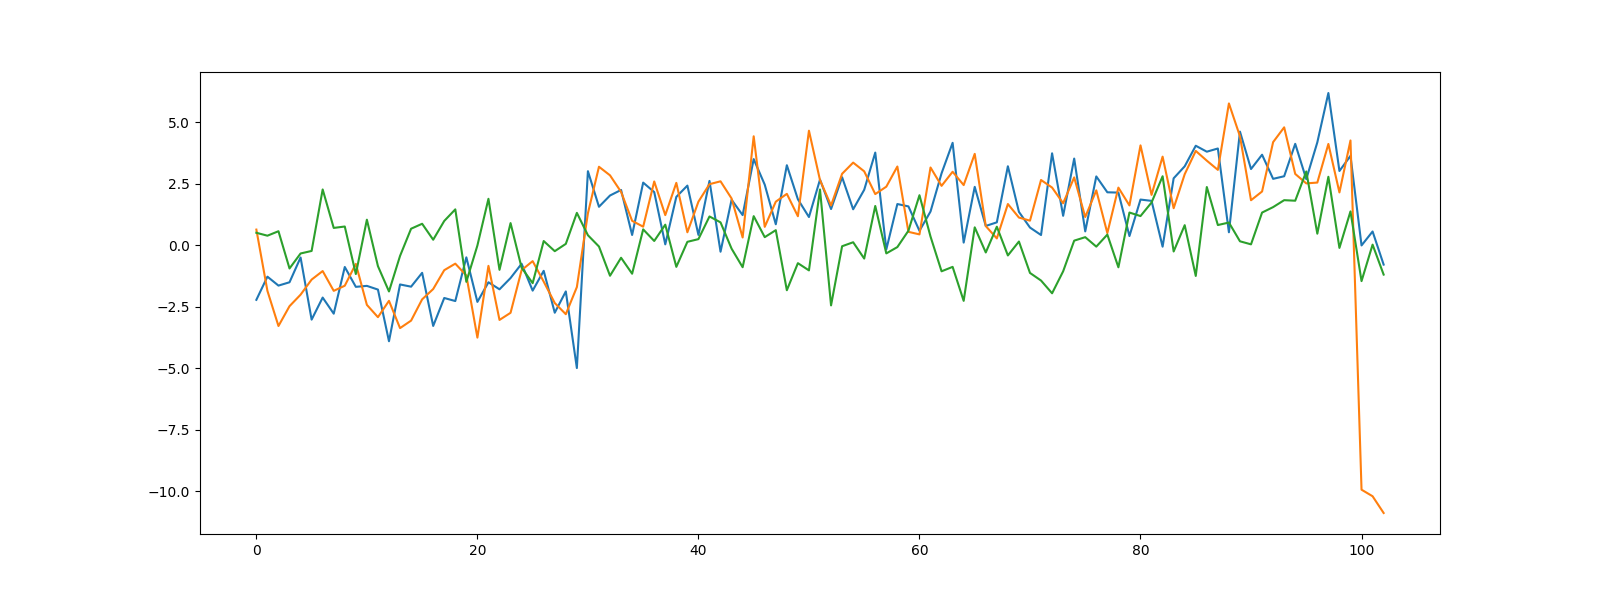

In [21]:
mv_mean_outlier = piecewise_normal_multivariate(
    means=[[-2, -2, 0], [2, 2, 0], [3, 3, 1], [0, -10, 0]],
    lengths=[30, 50, 20, 3],
    random_state=279,
)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(mv_mean_outlier);

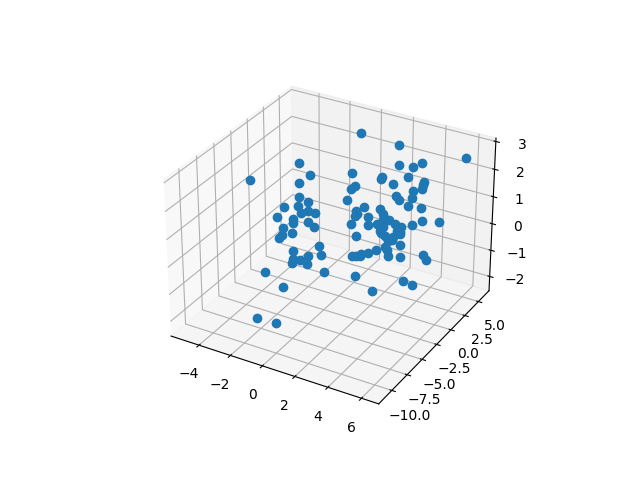

In [22]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(mv_mean_outlier[:, 0], mv_mean_outlier[:, 1], mv_mean_outlier[:, 2], "o")
plt.show()

In [23]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from sktime.transformations.series.dobin import DOBIN

scaler = MinMaxScaler()
X = scaler.fit_transform(mv_mean_outlier)
model = DOBIN()
X_outlier = model.fit_transform(pd.DataFrame(X))

C:\Users\n10907700\AppData\Local\Temp\ipykernel_23504\3333957037.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6, 6))


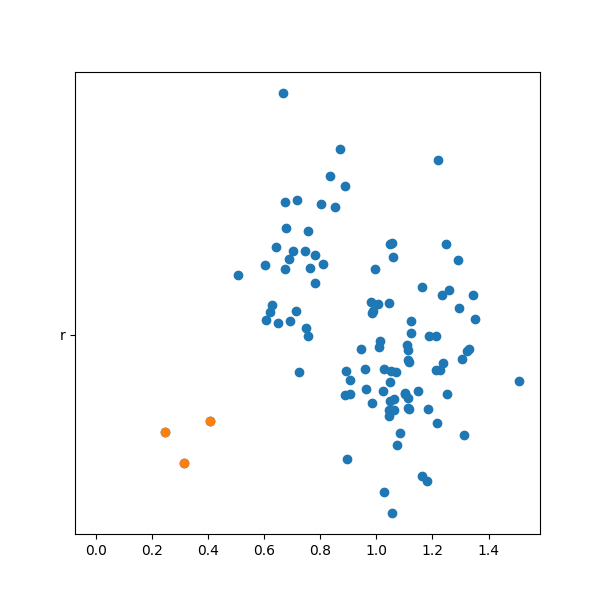

In [30]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(X_outlier["DB0"], X_outlier["DB1"], "o")
ax.plot(X_outlier["DB0"][100:], X_outlier["DB1"][100:], "o", "r")
plt.show()

In [25]:
from sklearn.decomposition import PCA

scaler = MinMaxScaler()
X = scaler.fit_transform(mv_mean_outlier)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

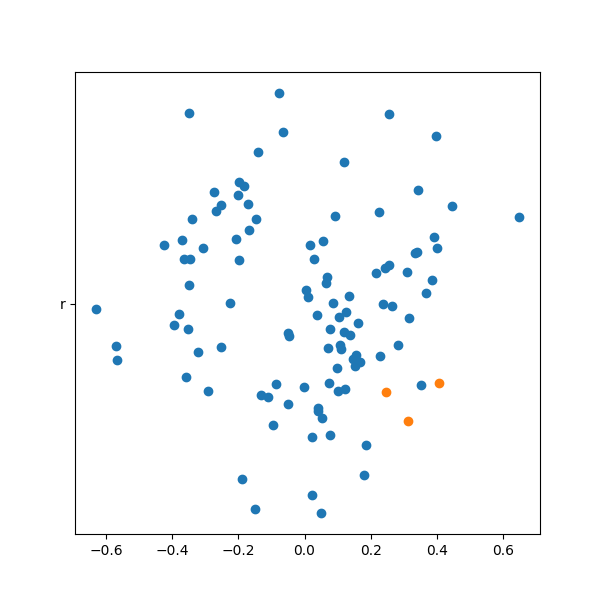

In [31]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(X_pca[:, 0], X_pca[:, 1], "o")
ax.plot(X_outlier["DB0"][100:], X_outlier["DB1"][100:], "o", "r")
plt.show()